# Applying Naive Bayes on Donors Choose

   <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>

In [111]:
import numpy as np 
import pandas as pd
from math import log10
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

In [112]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h1>1. Naive Bayes </h1>

## 1.1 Loading Data

In [113]:
data = pd.read_csv('/content/drive/MyDrive/6_Donors_choose_NB/preprocessed_data.csv')
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [114]:
data.shape

(109248, 9)

In [115]:
print('Percentage of projects approved:',data['project_is_approved'].value_counts(normalize=True)[1]*100)
print('Percentage of projects not approved:',data['project_is_approved'].value_counts(normalize=True)[0]*100)

Percentage of projects approved: 84.85830404217927
Percentage of projects not approved: 15.141695957820739


### Approach: 
1. Split your data.
2. Perform Bag of Words Vectorization of text data.
3. Perform tfidf vectorization of text data.
4. perform one-hot encoding of categorical features.
5. perform normalization of numerical features
6. For set 1 stack up all the features using hstack()
7. For set 2 stack up all the features using hstack()
8. Perform hyperparameter tuning and represent the training and cross-validation AUC scores for different 'alpha' values.
9. Find the best hyperparameter 'alpha' and fit the model. Plot ROC-AUC curve(by obtaining the probabilities using 'predict proba' method)
10. Plot confusion matrix based on the best threshold value
11. For the model in set 1 or in set 2, get the top 20 features associated with the positive and negative classes each.
12. Summarize observations and compare both the models(ie., from set 1 and set 2) in terms of optimal hyperparameter value, train AUC and test AUC scores. 
13. Use Prettytable format for comparison.

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [116]:
X = data.drop(columns='project_is_approved')
y =  data['project_is_approved']

In [118]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify = y)

In [119]:
print('Percentage of projects approved in Train:',100*(np.unique(y_train, return_counts=True)[1][1]/sum(np.unique(y_train, return_counts=True)[1])))
print('Percentage of projects not approved in Train:',100*(np.unique(y_train, return_counts=True)[1][0]/sum(np.unique(y_train, return_counts=True)[1])))
print('\n')
print('Percentage of projects approved in Test:',100*(np.unique(y_test, return_counts=True)[1][1]/sum(np.unique(y_test, return_counts=True)[1])))
print('Percentage of projects not approved in Test:',100*(np.unique(y_test, return_counts=True)[1][0]/sum(np.unique(y_test, return_counts=True)[1])))

Percentage of projects approved in Train: 84.85891427455576
Percentage of projects not approved in Train: 15.14108572544425


Percentage of projects approved in Test: 84.85647334504979
Percentage of projects not approved in Test: 15.143526654950204


<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

In [120]:
# Apply Bag of Words (BOW) vectorization on 'Preprocessed_Essay' 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df = 10, ngram_range = (1,2), max_features = 10000)
X_train_essay_bow = vectorizer.fit_transform(X_train['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)
ngrams_list_bow = vectorizer.get_feature_names()

In [121]:
#Let's look at the shape of our BOW Vectorized text features
print((X_train_essay_bow).shape, (X_test_essay_bow).shape)

(81936, 10000) (27312, 10000)


In [122]:
# Apply TF-IDF vectorization on 'Preprocessed_Essay' 
tfidf_vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features = 10000)
tfidf_vectorizer.fit(X_train['essay'].values)

X_train_essay_tfidf = tfidf_vectorizer.transform(X_train['essay'].values)
X_test_essay_tfidf = tfidf_vectorizer.transform(X_test['essay'].values)
ngrams_list_tfidf = tfidf_vectorizer.get_feature_names()

In [123]:
#Let's look at the shape of our TFIDF Vectorized text features
print((X_train_essay_tfidf).shape, (X_test_essay_tfidf).shape)

(81936, 10000) (27312, 10000)


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

Defining General Functions to transform Categorical and Numerical features

In [124]:
# Apply One-Hot Encoding on the categorical features either using OneHotEncoder() 
# Apply Normalization on the numerical features using Normalizer().
from sklearn.preprocessing import OneHotEncoder, Normalizer

#defining a general function which uses one hot encoder to return one hot encoded vector for each value in that particular feature of train and test
ohe = OneHotEncoder(handle_unknown='ignore')
def one_hot_encoded(ohe, feature):
    ohe.fit(X_train[feature].values.reshape(-1,1))
    train = ohe.transform(X_train[feature].values.reshape(-1,1))
    test = ohe.transform(X_test[feature].values.reshape(-1,1))
    category_names = ohe.categories_[0].tolist() #return category names also for each categorical feature
    return  train, test, category_names

#defining a general function which uses normalizer to return normalized value for each value in train and test
norm = Normalizer()
def normalized(norm, feature):
    #since Normalizer does not return the l2 norm value of train set, we separately calculate this and use this to transform our test set
    l2_norm = np.linalg.norm(X_train[feature].values)

    train = norm.fit_transform(X_train[feature].values.reshape(1,-1))
    test = X_test[feature].values.reshape(1, -1)/l2_norm #we use l2 norm of train values to transform test values because we cannot fit on test as that would lead to data leakage 

    return train.reshape(-1,1), test.reshape(-1,1)

Encoding Categorical Features

In [125]:
X_train_school_state_ohe, X_test_school_state_ohe, school_state_names = one_hot_encoded(ohe, 'school_state')
X_train_teacher_prefix_ohe, X_test_teacher_prefix_ohe,teacher_prefix_names =  one_hot_encoded(ohe, 'teacher_prefix')
X_train_project_grade_category_ohe, X_test_project_grade_category_ohe, project_grade_names = one_hot_encoded(ohe, 'project_grade_category')
X_train_clean_categories_ohe, X_test_clean_categories_ohe, clean_categories_names = one_hot_encoded(ohe, 'clean_categories')
X_train_clean_subcategories_ohe, X_test_clean_subcategories_ohe, clean_subcategories_names = one_hot_encoded(ohe, 'clean_subcategories')

In [126]:
#Let's look at the shape of our encoded categorical features
print(X_train_school_state_ohe.shape, X_test_school_state_ohe.shape)
print(X_train_teacher_prefix_ohe.shape, X_test_teacher_prefix_ohe.shape) 
print(X_train_project_grade_category_ohe.shape, X_test_project_grade_category_ohe.shape)
print(X_train_clean_categories_ohe.shape, X_test_clean_categories_ohe.shape)
print(X_train_clean_subcategories_ohe.shape, X_test_clean_subcategories_ohe.shape)

(81936, 51) (27312, 51)
(81936, 5) (27312, 5)
(81936, 4) (27312, 4)
(81936, 51) (27312, 51)
(81936, 395) (27312, 395)


Normalizing Numerical Features

In [127]:
X_train_price_norm, X_test_price_norm = normalized(norm, 'price')
X_train_teacher_no_prev_posted_projects_norm, X_test_teacher_no_prev_posted_projects_norm = normalized(norm, 'teacher_number_of_previously_posted_projects')

In [128]:
#Let's look at the shape of our normalized numerical features
print(X_train_price_norm.shape, X_test_price_norm.shape)
print(X_train_teacher_no_prev_posted_projects_norm.shape, X_test_teacher_no_prev_posted_projects_norm.shape)

(81936, 1) (27312, 1)
(81936, 1) (27312, 1)


<h2> 1.5 Stacking all the features </h2>

In [129]:
#store all the feature names derived from the original features in a list
features_list_bow = ngrams_list_bow + school_state_names + teacher_prefix_names + project_grade_names + clean_categories_names + clean_subcategories_names + ['price', 'teacher_no_prev_posted_projects']
features_list_tfidf = ngrams_list_tfidf + school_state_names + teacher_prefix_names + project_grade_names + clean_categories_names + clean_subcategories_names + ['price', 'teacher_no_prev_posted_projects']

In [130]:
len(features_list_tfidf), len(features_list_bow)

(10508, 10508)

In [131]:
#Stacking matrices column wise
#We create 2 sets of X_train and X_test one where essay feature is vectorized using BOW technique other where essay feature is vectorized using TFIDF technique
from scipy.sparse import hstack 
#BOW set
X_train_bow = hstack((X_train_essay_bow, X_train_school_state_ohe, X_train_teacher_prefix_ohe, 
                      X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, 
                      X_train_price_norm, X_train_teacher_no_prev_posted_projects_norm)).tocsr()

X_test_bow = hstack((X_test_essay_bow, X_test_school_state_ohe, X_test_teacher_prefix_ohe, 
                     X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, 
                     X_test_price_norm, X_test_teacher_no_prev_posted_projects_norm)).tocsr()

#TFIDF set
X_train_tfidf = hstack((X_train_essay_tfidf, X_train_school_state_ohe, X_train_teacher_prefix_ohe, 
                        X_train_project_grade_category_ohe, X_train_clean_categories_ohe, X_train_clean_subcategories_ohe, 
                        X_train_price_norm, X_train_teacher_no_prev_posted_projects_norm)).tocsr()

X_test_tfidf = hstack((X_test_essay_tfidf, X_test_school_state_ohe, X_test_teacher_prefix_ohe, 
                       X_test_project_grade_category_ohe, X_test_clean_categories_ohe, X_test_clean_subcategories_ohe, 
                       X_test_price_norm, X_test_teacher_no_prev_posted_projects_norm)).tocsr()

<h2>1.6 Applying NB on different kind of featurization as mentioned in the approach</h2>

Since the number of rows is huge we use a custom batch predict function which takes one batch at a time to predict probabilities corresponding to input vectors. 

In [132]:
def batch_predict(clf, data):
    #store the probability values in the below list
    y_prob = []
    
    rem = data.shape[0]%1000
    loop = data.shape[0] - rem
    for i in range(0, loop, 1000):
        y_prob.extend(clf.predict_proba(data[i:1000+i])[:,1]) #[:, 1] gives all values in column 1 that represents project approved probability
    
    #predict the probabilities for remaining rows
    if rem!=0:
        y_prob.extend(clf.predict_proba(data[loop:])[:,1])
    return y_prob

#### Set 1

In [133]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha'

#instead of allowing Naive Bayes to fit to class prior, we directly provide the class prior 
#we provide equal class prior to both classes so that neither of them have an unfair advantage just because data contains less points of any of them classes 
#in a sense we make likelihood term in the formula the main differentiator by providing equal class priors
multinb_bow_grid = MultinomialNB(class_prior=[0.5,0.5], fit_prior = False)

#alpha is the Laplace smoothing parameter
#Since Naive Bayes formula essentially relies on product of class prior and likelihood if any one value is 0 the whole term reduces to 0 
#Laplace smoothing is primarily used to avoid the probability being reduced to 0 
parameters = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
grid = GridSearchCV(multinb_bow_grid, parameters, cv = 5, scoring = 'roc_auc', n_jobs=-1, return_train_score=True)
grid.fit(X_train_bow, y_train)

results = pd.DataFrame.from_dict(grid.cv_results_)
results = results.sort_values(['param_alpha'])

train_auc = results['mean_train_score']
cv_auc = results['mean_test_score']
alpha = results['param_alpha'].apply(lambda x: log10(x)) #convert the alpha values to log(alpha)

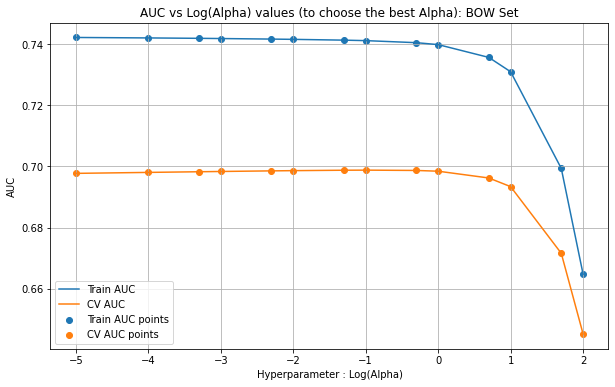

In [134]:
plt.figure(figsize=(10,6))
plt.plot(alpha, train_auc, label='Train AUC')
plt.scatter(alpha, train_auc, label='Train AUC points')

plt.plot(alpha, cv_auc, label='CV AUC')
plt.scatter(alpha, cv_auc, label='CV AUC points')

plt.xlabel("Hyperparameter : Log(Alpha)")
plt.ylabel("AUC")
plt.title("AUC vs Log(Alpha) values (to choose the best Alpha): BOW Set")
plt.grid()
plt.legend()
plt.show()

In [135]:
#final report from the Grid Search CV 
print(results[['param_alpha', 'mean_train_score','mean_test_score']])
print('Best Alpha:', grid.best_params_, '\nBest Score CV AUC from Best Alpha:', grid.best_score_)

   param_alpha  mean_train_score  mean_test_score
0      0.00001          0.742119         0.697735
2       0.0001          0.741969         0.698050
1       0.0005          0.741836         0.698265
4        0.001          0.741769         0.698355
3        0.005          0.741591         0.698550
6         0.01          0.741502         0.698625
5         0.05          0.741243         0.698762
7          0.1          0.741088         0.698793
8          0.5          0.740415         0.698688
9            1          0.739786         0.698442
10           5          0.735606         0.696228
11          10          0.730927         0.693404
12          50          0.699353         0.671629
13         100          0.664815         0.645285
Best Alpha: {'alpha': 0.1} 
Best Score CV AUC from Best Alpha: 0.6987932358256935


In [136]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Make class label and probability predictions on the train and test data.

#using best alpha 
best_alpha = grid.best_params_['alpha']
multinb_bow_best_alpha = MultinomialNB(alpha=best_alpha, class_prior=[0.5,0.5], fit_prior=False)
multinb_bow_best_alpha.fit(X_train_bow, y_train) 

#y_train_prob and y_test_prob are both list of probabilities of project being approved labeled by 1 i.e. P(y=1|x1,x2,x3,x4,...)
y_train_prob = batch_predict(multinb_bow_best_alpha, X_train_bow) 
y_test_prob = batch_predict(multinb_bow_best_alpha, X_test_bow)

#roc_curve takes different thresholds of probability every time to separate classes then calculates tpr and fpr for each threshold
#tpr and fpr values are then used in plotting the roc curve   
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_prob)

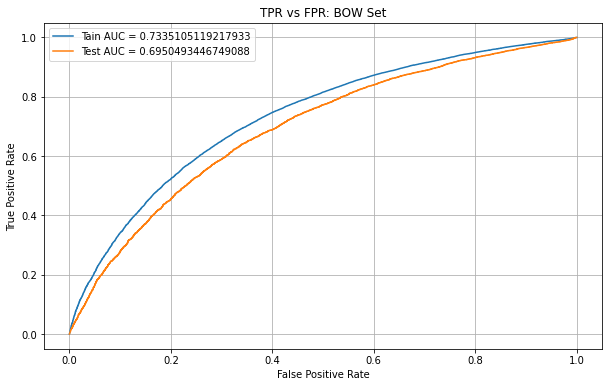

In [137]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.figure(figsize=(10,6))

plt.plot(train_fpr, train_tpr, label='Tain AUC = '+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label='Test AUC = '+str(auc(test_fpr, test_tpr)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPR: BOW Set")
plt.legend()
plt.grid()
plt.show()

In [138]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.

#Best threshold is the one where TPR is high and FPR is low
#so we need to maximize TPR and minimize FPR or in other words maximize (1-FPR), therefore we use TPR*(1-FPR) as a metric to find the best threshold
def find_best_threshold(threshold, fpr, tpr):
    #np.argmax returns the index of the highest valued element in the list 
    thresh = threshold[np.argmax(tpr*(1-fpr))] 
    print("The maximum value of TPR*(1-FPR)", max(tpr*(1-fpr)), "for threshold", np.round(thresh,3))
    return thresh

#below function uses the best threshold value as a condition to obtain predicted target classes (i.e. y_pred) from model predicted probabilities
#obtaining y_pred is essential for our next step which is evaluating the model performance
def predict_with_best_t(y_prob, thresh):
    y_pred = np.array([0 if x<thresh else 1 for x in y_prob])
    return y_pred

In [139]:
best_thresh = find_best_threshold(tr_thresholds, train_fpr, train_tpr)

y_train_pred = predict_with_best_t(y_train_prob, best_thresh)
y_test_pred = predict_with_best_t(y_test_prob, best_thresh)

confusion_train = confusion_matrix(y_train, y_train_pred)
confusion_test = confusion_matrix(y_test, y_test_pred)
print('Confusion Matrix of Train (BOW Set):\n', confusion_train)
print("-"*50)
print('Confusion Matrix of Test (BOW Set):\n', confusion_test)

The maximum value of TPR*(1-FPR) 0.45859444701126434 for threshold 0.377
Confusion Matrix of Train (BOW Set):
 [[ 8354  4052]
 [22178 47352]]
--------------------------------------------------
Confusion Matrix of Test (BOW Set):
 [[ 2562  1574]
 [ 7520 15656]]


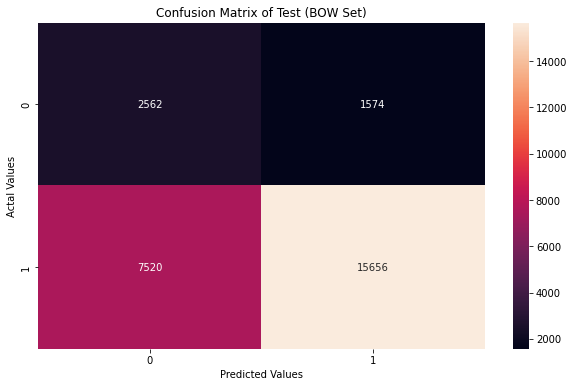

In [140]:
# Plotting the Confusion Matrix of Test Set
cm_test_df = pd.DataFrame(confusion_test,
                 index = [0, 1], 
                 columns = [0, 1])
plt.figure(figsize=(10,6))
sns.heatmap(cm_test_df, annot=True, fmt='g')
plt.title('Confusion Matrix of Test (BOW Set)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [141]:
print('Accuracy Score (BOW Set):', accuracy_score(y_test, y_test_pred))

Accuracy Score (BOW Set): 0.66703280609256


#### Set 2

<h5>Note: The procedure is completely same for TFIDF Set as for BOW set. To differentiate between variables created specifically for BOW and TFIDF set we have used an extra '_' at the end of variables created for TFIDF set e.g. grid (for BOW), grid_(for TFIDF)  </h5>

In [142]:
# Perform Hyperparameter Tuning.
# Plot the training and the CV AUC scores, for different values of 'alpha'

multinb_tfidf_grid = MultinomialNB(class_prior=[0.5,0.5], fit_prior=False)

param = {'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
grid_ = GridSearchCV(multinb_tfidf_grid, param, cv=5, scoring='roc_auc',n_jobs=-1, return_train_score=True)
grid_.fit(X_train_tfidf, y_train)

results_ = pd.DataFrame.from_dict(grid_.cv_results_)
results_ = results_.sort_values(['param_alpha'])

train_auc_ = results_['mean_train_score']
cv_auc_ = results_['mean_test_score']
alpha_ = results_['param_alpha'].apply(lambda x: log10(x))#convert the alpha values to log(alpha)

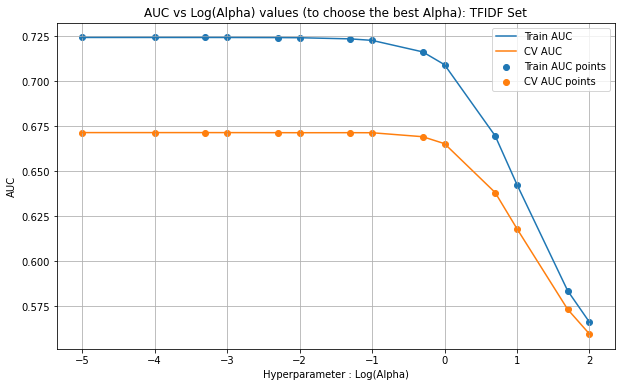

In [143]:
plt.figure(figsize=(10,6))
plt.plot(alpha_, train_auc_, label='Train AUC')
plt.scatter(alpha_, train_auc_, label='Train AUC points')

plt.plot(alpha_, cv_auc_, label='CV AUC')
plt.scatter(alpha_, cv_auc_, label='CV AUC points')

plt.xlabel("Hyperparameter : Log(Alpha)")
plt.ylabel("AUC")
plt.title("AUC vs Log(Alpha) values (to choose the best Alpha): TFIDF Set")
plt.grid()
plt.legend()
plt.show()

In [144]:
#final report from the Grid Search CV 
print(results_[['param_alpha', 'mean_train_score','mean_test_score']])
print('Best Alpha:', grid_.best_params_, '\nBest Score CV AUC from Best Alpha:', grid_.best_score_)

   param_alpha  mean_train_score  mean_test_score
0      0.00001          0.724272         0.671466
2       0.0001          0.724270         0.671465
1       0.0005          0.724264         0.671462
4        0.001          0.724257         0.671457
3        0.005          0.724199         0.671425
6         0.01          0.724126         0.671397
5         0.05          0.723494         0.671416
7          0.1          0.722655         0.671387
8          0.5          0.716271         0.669181
9            1          0.709162         0.665329
10           5          0.669653         0.638180
11          10          0.642574         0.618087
12          50          0.583704         0.573374
13         100          0.566237         0.559682
Best Alpha: {'alpha': 1e-05} 
Best Score CV AUC from Best Alpha: 0.6714660424520682


In [145]:
# Obtain the optimal value for 'alpha' and using the obtained optimal 'alpha' value, fit a multinomial naive bayes model, on the train data,
# Make class label and probability predictions on the train and test data.

#using best alpha 
best_alpha_ = grid_.best_params_['alpha']
multinb_tfidf_best_alpha = MultinomialNB(alpha=best_alpha_, class_prior=[0.5,0.5], fit_prior=False)
multinb_tfidf_best_alpha.fit(X_train_tfidf, y_train) 

#y_train_prob_ and y_test_prob_ are both list of probabilities of project being approved labeled by 1 i.e. P(y=1|x1,x2,x3,x4,...)
y_train_prob_ = batch_predict(multinb_tfidf_best_alpha, X_train_tfidf) 
y_test_prob_ = batch_predict(multinb_tfidf_best_alpha, X_test_tfidf)

#roc_curve takes different thresholds of probability every time to separate classes then calculates tpr and fpr for each threshold
#tpr and fpr values are then used in plotting the roc curve   
train_fpr_, train_tpr_, tr_thresholds_ = roc_curve(y_train, y_train_prob_)
test_fpr_, test_tpr_, te_thresholds_ = roc_curve(y_test, y_test_prob_)

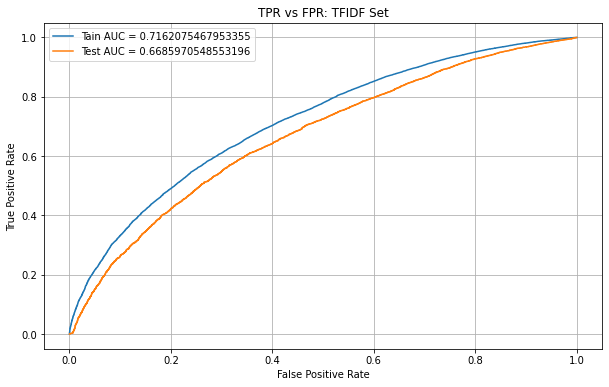

In [146]:
# Plot the ROC-AUC curves using the probability predictions made on train and test data.
plt.figure(figsize=(10,6))

plt.plot(train_fpr_, train_tpr_, label='Tain AUC = '+str(auc(train_fpr_, train_tpr_)))
plt.plot(test_fpr_, test_tpr_, label='Test AUC = '+str(auc(test_fpr_, test_tpr_)))

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPR: TFIDF Set")
plt.legend()
plt.grid()
plt.show()

In [147]:
# Pick the best threshold among the probability estimates, such that it has to yield maximum value for TPR*(1-FPR)
# Plot the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
best_thresh_ = find_best_threshold(tr_thresholds_, train_fpr_, train_tpr_)

y_train_pred_ = predict_with_best_t(y_train_prob_, best_thresh_)
y_test_pred_ = predict_with_best_t(y_test_prob_, best_thresh_)

confusion_train_ = confusion_matrix(y_train, y_train_pred_)
confusion_test_ = confusion_matrix(y_test, y_test_pred_)
print('Confusion Matrix of Train (TFIDF Set):\n', confusion_train_)
print("-"*50)
print('Confusion Matrix of Test (TFIDF Set):\n', confusion_test_)

The maximum value of TPR*(1-FPR) 0.42943521387550904 for threshold 0.519
Confusion Matrix of Train (TFIDF Set):
 [[ 8513  3893]
 [26017 43513]]
--------------------------------------------------
Confusion Matrix of Test (TFIDF Set):
 [[ 2595  1541]
 [ 8777 14399]]


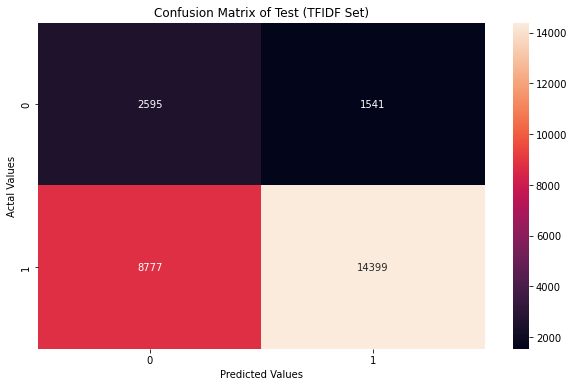

In [148]:
# Plotting the Confusion Matrix of Test Set
cm_test_df_ = pd.DataFrame(confusion_test_,
                 index = [0, 1], 
                 columns = [0, 1])
plt.figure(figsize=(10,6))
sns.heatmap(cm_test_df_, annot=True, fmt='g')
plt.title('Confusion Matrix of Test (TFIDF Set)')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [149]:
print('Accuracy Score (TFIDF Set):', accuracy_score(y_test, y_test_pred_))

Accuracy Score (TFIDF Set): 0.6222173403632103


<h1> Top 20 Features </h1>

To get the top features that are associated with a class we need to get the empirical log probabilities of features given the class, P(xi|y=1) and P(xi|y=0).We can easily get this from our model's attribute feature_log_prob_. 

refer - https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html

Let's get the top 20 features associated with positive and neagtive class from the model trained on our BOW Set.

In [179]:
# Either from set 1 (or) set 2, print the names of the top 20 features associated with the positive and negative classes each. (You have to print the names of the features, but not the indexes)
#get a list of the indices which represent the descending order of log probability values of class 0 and class 1
#argsort function sorts indices in ascending order of log probability values but since we need to get this in descending order we use [::-1] to reverse the array
class_0_indices_desc = np.argsort(multinb_bow_best_alpha.feature_log_prob_[0])[::-1]
class_1_indices_desc = np.argsort(multinb_bow_best_alpha.feature_log_prob_[1])[::-1]

top_20_neg = class_0_indices_desc[:20].tolist()
top_20_pos = class_1_indices_desc[:20].tolist()

In [180]:
print('Top 20 Features associated with negative class:')
[print(i) for i in (np.array(features_list_bow)[top_20_neg])]
print('\n')
print('Top 20 Features associated with positive class:')
[print(i) for i in (np.array(features_list_bow)[top_20_pos])]
print('\n')

Top 20 Features associated with negative class:
students
school
learning
my
classroom
not
learn
they
help
the
my students
nannan
many
we
need
work
come
love
able
reading


Top 20 Features associated with positive class:
students
school
my
learning
classroom
the
they
not
my students
learn
help
many
nannan
we
need
work
reading
use
love
day




Most features appear to be in strong association with both classes although there are a few features that are exclusive to each class. Also the order of importance of features is slightly different.

<h1>3. Summary</h1>

<br> as mentioned in the step 5 of instructions

In [181]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyperparameters", "AUC"]
x.add_rows(
    [
        ["Bag of Words", 'Multinomial Naive Bayes', 1, 0.69],
        ["TFIDF", 'Multinomial Naive Bayes', 1, 0.66]
    ]
)

print(x)

+--------------+-------------------------+-----------------+------+
|  Vectorizer  |          Model          | Hyperparameters | AUC  |
+--------------+-------------------------+-----------------+------+
| Bag of Words | Multinomial Naive Bayes |        1        | 0.69 |
|    TFIDF     | Multinomial Naive Bayes |        1        | 0.66 |
+--------------+-------------------------+-----------------+------+


Summary: 

1. Split the dataset into train and test
2. Convert Categorical features into a vector using one hot encoding
3. Normalize the Numerical features using sklearn's Normalizer
4. Convert Text feature to a vector using BOW technique and TFIDF technique
5. Now create 2 sets, one by merging the categorical and numerical feature with BOW form of text feature and other by merging the categorical and numerical features with TFIDF form of text feature.
6. Train MultinomialNB Model on both BOW train set and TFIDF train set with optimal value of hyperparameter alpha. Before that, find the optimal value of hyperparameter using GridSearchCV based on ROC AUC scoring for each set. 
7. After you train the model with optimal hyperparameter find the best probability threshold to separate the classes, this can be obtained by finding the probability which maximizes TPR*(1-FPR) value. 
8. Use the threshold to obtain predicted class values, then compute performance metrics like Confusion Matrix and Accuracy score.

Comparison between Models: 
1. Model trained on BOW set depicts better performance metrics than the Model which is trained on TFIDF set. The Test AUC score of Model-1(BOW) is 0.69 which is higher than score of Model-2(TFIDF) 0.66, implying that Model-1 has a better potential at predicting correct classes in test set if provided with an optimal probability threshold.
2. Also, the Train AUC score of Model-1(BOW) is 0.73 which is higher than score of Model-2(TFIDF) 0.71, implying that Model-1 has a better potential at predicting correct classes in train set if provided with an optimal probability threshold.
3. The Laplace smoothing parameter 'alpha' has an optimal value 0.1 for Model-1(BOW) which indicates that the empirical probabilities P(xi|y) are altered by a significant amount as compared to Model-2(TFIDF) which uses an optimal alpha value of 0.00001 which indicates tha the empirical probabilities P(xi|y) are altered by a very small amount. 

Conclusion: 
Our Multinomial Naive Bayes Classifier works better with the input set that contains Bag of Words vectoriztion of essay feature as compared to TFIDF vectorization. 